# 6. SymPy 符號運算好幫手

In [1]:
%pylab inline 
from sympy import *
init_printing(use_unicode = True)

Populating the interactive namespace from numpy and matplotlib


## 6.1 從實例開始
### 6.1.1 Eular 恆等式
$e^{i\pi} + 1 = 0$

In [2]:
E**(I * pi) + 1 == 0

True

In [3]:
x = symbols('x')
expr = E**(I*x)
expr

In [4]:
expr.rewrite(sin)

In [5]:
expand(expr)

In [6]:
expand(expr, complex = True)

In [7]:
expand(exp(I*x), complex = True)

In [8]:
x = symbols('x', real = True)
expand(exp(I*x), complex = True)

In [9]:
s = series(exp(I*x), x, 0, 10)  # 泰勒多項式展開
s

In [10]:
re(s)

In [11]:
im(s)

In [12]:
series(cos(x), x, 0, 10)

In [13]:
expr = (exp(I*x) - cos(x))
expr

In [14]:
expr.rewrite(sin)

In [15]:
simplify(expr)

### 6.1.2 球體體積

In [16]:
integrate(x * sin(x), x)

In [17]:
integrate(x * sin(x), (x, 0, 2*pi))

In [18]:
x, y = symbols('x y')
r = symbols('r', positive = True)
y = sqrt(r**2 - x**2)
circle_area = integrate(y, (x, -r, r)) * 2
circle_area

In [19]:
circle_area.subs(r, 3)

In [20]:
circle_volume = integrate(circle_area.subs(r, sqrt(r**2 - x**2)), (x, -r, r))
circle_volume

In [21]:
circle_volume.subs(r, 3)

### 6.1.3 數值微分
兩點公式：  

$f'(x) = \frac{f(x + h) - f(x)}{h}$

In [22]:
x = symbols('x', real = True)
h = symbols('h', positive = True)
f = symbols('f', cls = Function)

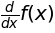

In [23]:
f_diff = f(x).diff(x, 1) # 微分
f_diff

In [24]:
# 使用 as_finite_diff()，將 f的導函數 改用 四點公式來表達
expr_diff = as_finite_diff(f_diff, [x, x - h, x-2*h, x-3*h])  # 將 f'(x) 轉為  [x, x - h, x-2*h, x-3*h] 的N點公式
expr_diff

In [25]:
as_finite_diff(f_diff, [x, x-h, x-2*h])

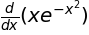

In [26]:
# f的導函數，設定 f(x) = x * e^-x^2
sym_dexpr = f_diff.subs(f(x), x * exp(-x**2))
sym_dexpr
# 這是一個 Derivative 物件

In [27]:
sym_dexpr.doit()
# 把 Derivative 展開成為一個 expression 物件

In [28]:
(x*exp(-x**2)).diff()
# 展開成為一個 expression 物件

In [29]:
# 把 symbolic expression 經過 lambdify 成為一個數值函數
sym_dfunc = lambdify([x], sym_dexpr.doit(), modules = 'numpy')
sym_dfunc(np.array([-1, 0, 1]))
# 可以帶入數值計算結果

array([-0.36787944,  1.        , -0.36787944])

In [30]:
# 導函數的四點公式
expr_diff

In [31]:
# expression 中的 arguments
expr_diff.args

In [32]:
# expression 中的 function
expr_diff.func

sympy.core.add.Add

In [33]:
# 萃取每個 arguments 的係數與參數
w = Wild('w')
c = Wild('c')
patterns = [arg.match(c * f(w)) for arg in expr_diff.args]
patterns

In [34]:
# 萃取每個 argument 的係數
coefficients = [t[c] for t in sorted(patterns, key = lambda t:t[w])]
coefficients

In [35]:
# 要依據四點公式估算 導數，先假設 h 等於一個很小的值
coeff_arr = np.array([float(coeff.subs(h, 1e-3)) for coeff in coefficients])
coeff_arr

array([ -333.33333333,  1500.        , -3000.        ,  1833.33333333])

In [36]:
numpy.ndarray.itemsize?

In [37]:
def moving_window(x, size):
    from numpy.lib.stride_tricks import as_strided
    x = np.ascontiguousarray(x)
    # 把原來的 array 切成很多部份重疊的 windows，新的shape 是 (n - window_size +1, window_size)
    return as_strided(x, shape = (x.shape[0] - size + 1, size), strides = (x.itemsize, x.itemsize))

x_arr = np.arange(-2, 2, 1e-3)  # 設定要估算導數的 x 區間
y_arr = x_arr * np.exp(-x_arr **2)  # 計算 f(x) = x * e**(-x**2) 的值
num_res = (moving_window(y_arr, 4) * coeff_arr).sum(axis = 1)  # 用 四點公式，假設 h = 0.001, 計算x軸每個點的導數
sym_res = sym_dfunc(x_arr[3:])  # 用 lambdify 的 symbolic 函數計算導數
np.max(np.abs(num_res - sym_res))

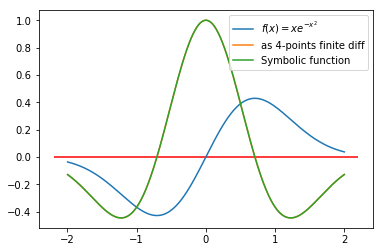

In [38]:
plt.plot(x_arr[3:], y_arr[3:], label = '$f(x) = x e^{-x^2}$')
plt.plot(x_arr[3:], num_res, label = 'as 4-points finite diff')
plt.plot(x_arr[3:], sym_res, label = 'Symbolic function') 
plt.hlines(0, plt.xlim()[0], plt.xlim()[1], 'red')
plt.legend();

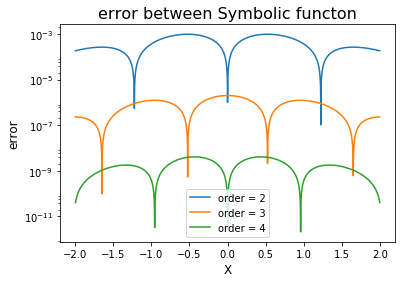

In [39]:
def finite_diff_coefficients(f_diff, order, h, h_value): 
    points = [x - i * h for i in range(order)]
    expr_diff = as_finite_diff(f_diff, points)
    w = Wild('w')
    c = Wild('c')    
    patterns = [arg.match(c * f(w)) for arg in expr_diff.args]
    coefficients = [t[c] for t in sorted(patterns, key = lambda t:t[w])] 
    coeff_arr = np.array([float(coeff.subs(h, h_value)) for coeff in coefficients]) 
    return coeff_arr

    
orders = [2, 3, 4]
h = 1e-3

for order in orders:
    coeff_arr = finite_diff_coefficients(f_diff, order, h, 1e-3)
    num_res = (moving_window(y_arr, order) * coeff_arr).sum(axis = 1)
    sym_res = sym_dfunc(x_arr[order - 1:])
    error_res = np.abs(num_res - sym_res)
    plt.semilogy(x_arr[order - 1:], error_res, label = 'order = {}'.format(order))
    plt.title('error between Symbolic functon', fontsize = 16)
    plt.xlabel('X', fontsize = 12)
    plt.ylabel('error', fontsize = 12)
plt.legend();    

## 6.2 數學運算式

### 6.2.1 Symbol

In [40]:
# var 快速建立 symbols，並注入到 globals
var('x0 y0 x1 y1')

In [41]:
type(x0)

sympy.core.symbol.Symbol

In [42]:
x0.name

'x0'

In [43]:
type(x0.name)

str

In [44]:
# 用 symbols 建立
x1, y1 = symbols('x1 y1')
type(x1)

sympy.core.symbol.Symbol

In [45]:
# 用 Symbol 建立
x2 = Symbol('x2')
type(x2)

sympy.core.symbol.Symbol

In [46]:
# 變數與 symbol 的 name 可以不一樣
t = x0
a, b = symbols('alpha, beta')
a, b

In [47]:
type(a)

sympy.core.symbol.Symbol

In [48]:
a.name

'alpha'

In [49]:
# symbol name 最好用正統名稱
sin(a) + sin(b) + t

In [50]:
ta = symbols('theta')
ta

In [51]:
sin(ta)

In [52]:
# 對 symbol 設定一些 假設條件
m, n = symbols('m, n', integer = True)
x = symbols('x', positive = True)

In [53]:
x.is_positive

True

In [54]:
# is_xxx 屬性
is_attrs = [attr for attr in dir(x) if attr.startswith('is_')]
sorted(is_attrs)

['is_Add',
 'is_AlgebraicNumber',
 'is_Atom',
 'is_Boolean',
 'is_Derivative',
 'is_Dummy',
 'is_Equality',
 'is_Float',
 'is_Function',
 'is_Integer',
 'is_Matrix',
 'is_Mul',
 'is_Not',
 'is_Number',
 'is_NumberSymbol',
 'is_Order',
 'is_Piecewise',
 'is_Point',
 'is_Poly',
 'is_Pow',
 'is_Rational',
 'is_Relational',
 'is_Symbol',
 'is_Vector',
 'is_Wild',
 'is_algebraic',
 'is_algebraic_expr',
 'is_antihermitian',
 'is_commutative',
 'is_comparable',
 'is_complex',
 'is_composite',
 'is_constant',
 'is_even',
 'is_finite',
 'is_hermitian',
 'is_hypergeometric',
 'is_imaginary',
 'is_infinite',
 'is_integer',
 'is_irrational',
 'is_negative',
 'is_noninteger',
 'is_nonnegative',
 'is_nonpositive',
 'is_nonzero',
 'is_number',
 'is_odd',
 'is_polar',
 'is_polynomial',
 'is_positive',
 'is_prime',
 'is_rational',
 'is_rational_function',
 'is_real',
 'is_transcendental',
 'is_zero']

In [55]:
# assumptions
x.assumptions0

{'commutative': True,
 'complex': True,
 'hermitian': True,
 'imaginary': False,
 'negative': False,
 'nonnegative': True,
 'nonpositive': False,
 'nonzero': True,
 'positive': True,
 'real': True,
 'zero': False}

In [56]:
# Basic 為所有物件之母
x.__class__.mro()

[sympy.core.symbol.Symbol,
 sympy.core.expr.AtomicExpr,
 sympy.core.basic.Atom,
 sympy.core.expr.Expr,
 sympy.logic.boolalg.Boolean,
 sympy.core.basic.Basic,
 sympy.core.evalf.EvalfMixin,
 object]

### 6.2.2 數值

In [57]:
1/2 + 1/3

In [58]:
# 用 S 建立 SymPy 體系的數值
S(1)/2 + S(1)/3

In [59]:
# Rational
r = S(5)/6
type(r)

sympy.core.numbers.Rational

In [60]:
# 用 N 還估計數值
N(r, 50)

In [61]:
# N 可以指定精度
N(1.1, 60)

In [62]:
N(0.1, 60)

In [63]:
# 用 字串來建立 Float 物件，精度才不會跑掉
N(Float('0.1', 60), 60)

In [64]:
# 指定的精度要足夠
N(Float('0.1', 60), 65)

In [65]:
N(pi, 50)

In [66]:
N(sqrt(2), 50)

### 6.2.3 運算子和函數

In [67]:
# operators 依然繼承 Basic
Add.mro()

[sympy.core.add.Add,
 sympy.core.expr.Expr,
 sympy.core.operations.AssocOp,
 sympy.core.basic.Basic,
 sympy.core.evalf.EvalfMixin,
 object]

In [68]:
var('x y z')

In [69]:
Add(x, y, z)

In [70]:
# Expression 是一棵樹
Add(Mul(x, y, z), Pow(x, y), sin(z))

In [71]:
# 四則運算有經過 operators override
x*y*z + x**y + sin(z)

In [72]:
t = x - y
t

In [73]:
# SymPy 中沒有減法 或 除法
type(t)

sympy.core.add.Add

In [74]:
t.func

sympy.core.add.Add

In [75]:
t.args

In [76]:
t.args[0].name

'x'

In [77]:
t.args[0].func

sympy.core.symbol.Symbol

In [78]:
t.args[0].args
# Expression 是一棵樹

In [79]:
f = Function('f')
f
# f 是一個繼承 Function 的類別，而不是 Function 的實例

f

In [80]:
type(f)

sympy.core.function.UndefinedFunction

In [81]:
issubclass(f, Function)
# f 是一個繼承 Function 的類別，而不是 Function 的實例

True

In [82]:
t = f(x, y)
t

In [83]:
type(f)

sympy.core.function.UndefinedFunction

In [84]:
type(t)
# t 是 f 類別的實例

f

In [85]:
t**2 + t
# 可以代表 f 來作四則運算

### 6.2.4 萬用字元

In [86]:
x, y = symbols('x y')
expr = 3 * x * (x + y) **2
expr

In [87]:
# 用 Wild 符號 和 match 方法，在一個 expression 中尋找特定 pattern
a = Wild('a')
b = Wild('b')
expr.match(a * b**2)

In [88]:
# find
expr =  (x + y) **3
expr

In [89]:
expr = expr.expand()
expr

In [90]:
expr.find(a * b**2)
# find() 方法會在 expression 樹狀結構中尋找所有符合範本的子樹
# 2 也出現！

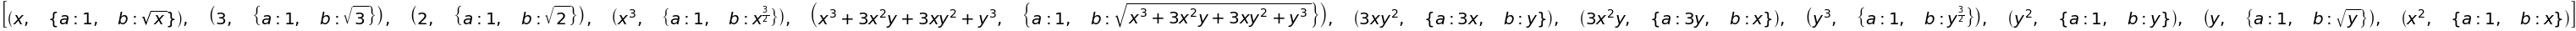

In [91]:
def find_match(expr, pattern):
    return [(e, e.match(pattern)) for e in expr.find(pattern)]

expr = ((x + y) **3).expand()
find_match(expr, a*b**2)

In [92]:
a = Wild('a', exclude = [1, Pow])
b = Wild('b', exclude = [1, Pow])
# 用 exclude 限制 萬用字元的篩選條件

expr = expand((x + y)**3)
expr

In [93]:
find_match(expr, a*b**2)

In [94]:
# 用 replace 取代 子運算式
expr.replace(a*b**2, (a+b)**2)

In [95]:
expr

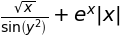

In [96]:
x, y = symbols('x, y', real = True)

# 用 WildFunction 來定義與任意函數符合的萬用字元
expr = sqrt(x) / sin(y**2) + abs(exp(x) * x)
expr

In [97]:
f = WildFunction('f') # 代表任意一個函數

find_match(expr, f)

## 6.3 符號運算

In [98]:
# simplify 用來簡化
expr = (x + 2)**2 - (x + 1)**2
expr

In [99]:
simplify(expr)

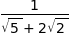

In [100]:
# radsimp 對分母進行有理化
expr = 1 / (sqrt(5) + 2 * sqrt(2))
expr

In [101]:
radsimp(expr)

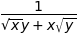

In [102]:
# 對有號的運算進行處理
expr = 1/(y * sqrt(x) + x * sqrt(y))
expr

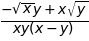

In [103]:
radsimp(expr)

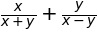

In [104]:
# radsimp 對分母進行通分
expr = x / (x + y) + y / (x-y)
expr

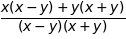

In [105]:
radsimp(expr)

In [106]:
# fraction() 傳回運算式的分子與分母
fraction(radsimp(1/x + 1/y))

In [107]:
# fraction 不對對運算式通分
fraction(1/x + 1/y)

In [108]:
# cancel 用來約分
cancel((x**2 - 1)/(x + 1))

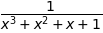

In [109]:
# 因式分解
expr = 1/(x**3 + x**2 + x +1)
expr

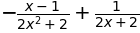

In [110]:
apart(expr)

In [111]:
# trigsimp 用來簡化 三角函數運算式
expr = sin(x)**2 + 2 * sin(x) * cos(x) + cos(x)**2
expr

In [112]:
trigsimp(expr)

In [113]:
# expand_trig() 用來展開三角函數運算
expand_trig(sin(2*x + y))

In [121]:
# expand() 可以透過參數來設定是否要展開特定的運算
x, y, z = symbols('x y z', positive = True)
expand(x * log(y * z), mul = True)

In [122]:
expand(x * log(y * z), mul = False)

In [123]:
expand((x*y)**z, power_base = True)

In [124]:
expand((x*y)**z, power_base = False)

In [125]:
# 複數展開
x, y = symbols('x y', complex = True)
expand(x * y, complex = True)

In [126]:
# function 展開
expand(gamma(1 + x), func = True)

In [127]:
# 三角函數展開
expand(sin(x + y), trig = True)

In [133]:
expand(sin(x + y), trig = False)

In [131]:
sin(x + y).expand(trig = True)

In [132]:
expand_trig(sin(x + y))

In [134]:
# factor 做 因式分解
expr = 15 * x**2 + 2 * y - 3 * x- 10 * x * y
expr

In [136]:
factor(expr)

In [141]:
# collect , 用來 以指定的變數為基準，收集多項式的各階係數
eq = (1 + a * x)**3 + (1 + b * x)**2
eq

In [142]:
eq2 = expand(eq)
eq2

In [144]:
p = collect(eq2, x)
p 

In [145]:
# evaluate = False, 傳回各階與其係數的字典
p = collect(eq2, x, evaluate = False)
p

In [152]:
# 用 coeff() 也可獲得特定階層的係數
eq2.coeff(x, 2)

In [156]:
# 用 collect 收集特定階層的係數
collect(a * sin(2 * x) + b * sin(2 *x ), sin(2 * x))

### 6.3.2 方程式

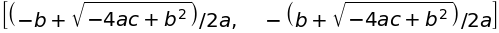

In [157]:
# 用 solve 解方程式
a, b, c = symbols('a b c')
solve(a * x**2 + b * x + c, x)

In [166]:
# 解 方程組，須指定變數
solve((x**2 + x * y + 1, y**2 + x * y + 2), x, y)

In [167]:
# 用 roots() 求根
expr = x**3 - 3 * x**2 + x + 1
expr

In [168]:
roots(expr)

### 6.3.3 微分

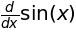

In [169]:
# Derivative，傳回一個導函數
t = Derivative(sin(x), x)
t

In [171]:
# 用 doit() 求導
t.doit()

In [172]:
# 也可以用 diff() 直接求導數
diff(sin(x), x)

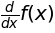

In [173]:
# 用 Derivative 對自訂的數學函數求導函數
Derivative(f(x), x)

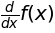

In [174]:
diff(f(x), x)

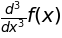

In [175]:
# 求高階的導函數
Derivative(f(x), x, 3)

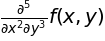

In [176]:
# 偏導數
Derivative(f(x, y), x, 2, y, 3)

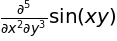

In [177]:
Derivative(sin(x*y), x, 2, y, 3)

In [178]:
Derivative(sin(x*y), x, 2, y, 3).doit()

In [180]:
diff(sin(x*y), x, 2, y, 3)

### 6.3.4 微分方程

In [184]:
# dsolve() 可以對微分方程進行符號求解
x = symbols('x')
f = symbols('f', cls = Function)
dsolve(Derivative(f(x), x) - f(x), f(x))  # f'(x) = f(x),求解 f(x)

In [189]:
# classify_ode() 可以檢視可用的微分方程的解法
eq = Eq(f(x).diff(x) + f(x), (cos(x) - sin(x)) * f(x)**2)
classify_ode(eq, f(x))

('1st_power_series', 'lie_group')

In [191]:
dsolve(eq, f(x))

In [192]:
# 用 hint 指定 解法
dsolve(eq, f(x), hint = '1st_power_series')

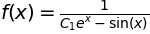

In [193]:
dsolve(eq, f(x), hint = 'lie_group')

In [194]:
# hint = 'all', 嘗試各種解法
dsolve(eq, f(x), hint = 'all')

{'1st_power_series': Eq(f(x), C1 - C1*x**2/2 - C1*x**3/6 + C1*x**4/4 + C1*x**5*(-C1*(C1 - 3) - C1*(C1 + 1) + 4*C1 + 12)/120 + O(x**6)),
 'best': Eq(f(x), 1/(C1*exp(x) - sin(x))),
 'best_hint': 'lie_group',
 'default': '1st_power_series',
 'lie_group': Eq(f(x), 1/(C1*exp(x) - sin(x))),
 'order': 1}

In [196]:
ode.allhints

('separable',
 '1st_exact',
 '1st_linear',
 'Bernoulli',
 'Riccati_special_minus2',
 '1st_homogeneous_coeff_best',
 '1st_homogeneous_coeff_subs_indep_div_dep',
 '1st_homogeneous_coeff_subs_dep_div_indep',
 'almost_linear',
 'linear_coefficients',
 'separable_reduced',
 '1st_power_series',
 'lie_group',
 'nth_linear_constant_coeff_homogeneous',
 'nth_linear_euler_eq_homogeneous',
 'nth_linear_constant_coeff_undetermined_coefficients',
 'nth_linear_euler_eq_nonhomogeneous_undetermined_coefficients',
 'nth_linear_constant_coeff_variation_of_parameters',
 'nth_linear_euler_eq_nonhomogeneous_variation_of_parameters',
 'Liouville',
 '2nd_power_series_ordinary',
 '2nd_power_series_regular',
 'separable_Integral',
 '1st_exact_Integral',
 '1st_linear_Integral',
 'Bernoulli_Integral',
 '1st_homogeneous_coeff_subs_indep_div_dep_Integral',
 '1st_homogeneous_coeff_subs_dep_div_indep_Integral',
 'almost_linear_Integral',
 'linear_coefficients_Integral',
 'separable_reduced_Integral',
 'nth_linear_co

### 6.3.5 積分

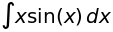

In [199]:
# Integral() 
e = Integral(x * sin(x), x)
e

In [200]:
e.doit()
# 進行積分運算

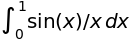

In [201]:
e2 = Integral(sin(x)/x , (x, 0, 1))
e2
# 積分運算式

In [202]:
e2.doit()
# 進行積分運算

In [203]:
e2.evalf()
# 使用 evalf() 進行數值運算

In [204]:
e2.evalf(50) 
# 指定精度

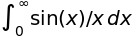

In [205]:
e3 = Integral(sin(x)/x, (x, 0, np.inf))
e3

In [208]:
e3.evalf(50)
# 這是錯誤的

In [209]:
e3.doit()
# 應該等於 pi/2

## 6.4 輸出符號運算式
### 6.4.1 lambdify

In [214]:
# lambdify() 可將 expression 轉換為 數值運算函數

a, b ,c, x = symbols('a, b, c, x', real = True)  # 定義 symbols，皆為實數
quadratic_roots = solve(a*x**2 + b*x + c, x)  # 產生一個 解的list
lam_quadratic_roots_real = lambdify([a, b, c], quadratic_roots)  # 建立一個 lambdify 的 function
type(lam_quadratic_roots_real)

function

In [216]:
lam_quadratic_roots_real(2, -3, 1)

In [219]:
# 使用 lambdify 的 modules 參數，指定相依模組
import cmath
lam_quadratic_roots_real = lambdify([a, b, c], quadratic_roots, modules = [cmath])  
lam_quadratic_roots_real(2, 2, 1)

[(-0.5+0.5j), (-0.5-0.5j)]

In [244]:
lam_quadratic_roots_real = lambdify([a, b, c], quadratic_roots, modules = [numpy])  

A = np.array([2, 2, 1, 1], dtype = np.complex)
B = np.array([2, 4, 2, 1], dtype = np.complex)
C = np.array([1, 1, 1, 2], dtype = np.complex) 
s = lam_quadratic_roots_real(A, B, C)
s

[array([-0.50000000+0.5j       , -0.29289322+0.j        ,
        -1.00000000+0.j        , -0.50000000+1.32287566j]),
 array([-0.50000000-0.5j       , -1.70710678+0.j        ,
        -1.00000000+0.j        , -0.50000000-1.32287566j])]

In [245]:
s[0].shape

### 6.4.2 用 autowrap() 編譯運算式

### 6.4.3 使用 cse() 分步輸出運算式

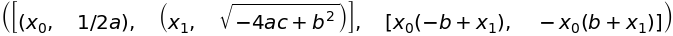

In [247]:
replacements, reduced_exprs = cse(quadratic_roots)
replacements, reduced_exprs 
# cse() 輸出兩個 lists
# 第一個 list: 臨時變數與運算式
# 第二個 list: 運算結果，可以分析 公共運算式

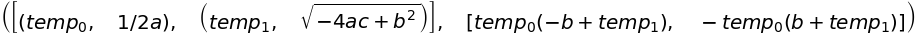

In [248]:
# 用 symbols 參數修改臨時變數的 prefix
replacements, reduced_exprs = cse(quadratic_roots, symbols = numbered_symbols('temp'))
replacements, reduced_exprs 

## 6.5 機械運動模擬

In [249]:
from sympy.physics.mechanics import *
I = ReferenceFrame('I')                # 定義慣性參照系
O = Point('O')                         # 定義原點
O.set_vel(I, 0)                        # 設定點O在參照系I中的速度為0
g = symbols("g")

In [250]:
q = dynamicsymbols("q")
u = dynamicsymbols("u")
m1 = symbols("m1")
P1 = Point('P1')                    
P1.set_pos(O, q * I.x)              # 點P1的位置相對於點O，沿著參照系I的X軸偏移q
P1.set_vel(I, u * I.x)              # 點P1在參照系I中的速度為X軸方向，大小為u
box = Particle('box', P1, m1)       # 在點P1處放置質量為m1的方塊box

In [251]:
q, u

In [252]:
th = dynamicsymbols("theta")
w  = dynamicsymbols("omega")
B = I.orientnew('B', 'Axis', [th, I.z])  # 將I圍繞Z軸旋轉theta得到參照系B
B.set_ang_vel(I, w * I.z)                # 設定B的角速度

In [253]:
l, m2 = symbols("l,m2")
P2 = P1.locatenew('P2', -l * B.y)  # P2相對於P1沿著B的Y軸負方向偏移l
P2.v2pt_theory(P1, I, B)           # 使用二點理論設定P2在I中的速度
ball = Particle('ball', P2, m2)    # 在P2處放置質量為m2的小球 

In [254]:
P2.vel(I) #顯示P2在I中的速度

In [255]:
eqs = [q.diff() - u, th.diff() - w] #q的導數為u，th的導數為w
kane = KanesMethod(I, q_ind=[q, th], u_ind=[u, w], kd_eqs=eqs)

In [256]:
particles = [box, ball]  #系統包括的所有質點
forces = [(P1, -m1*g*I.y), (P2, -m2*g*I.y)] #系統所受的外力
fr, frstar = kane.kanes_equations(forces, particles)

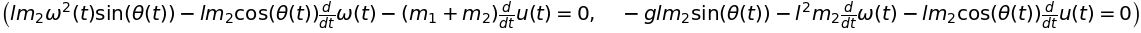

In [259]:
Eq(fr[0] + frstar[0], 0), Eq(fr[1] + frstar[1], 0)

In [260]:
from IPython import display
status = Matrix([[q],[th],[u],[w]])
display.Math(latex(kane.mass_matrix_full) + latex(status.diff()) + 
             "=" + latex(kane.forcing_full))

<IPython.core.display.Math object>

### 將符號表達式轉為程式

In [261]:
diff_status = kane.mass_matrix_full.inv() * kane.forcing_full